#**Mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Loading Pre-Processed Data**

In [ ]:
import pandas as pd

df_preprocessed = pd.read_csv('/content/drive/MyDrive/Computational Intelligence in Automation/preprocessed_data.csv')
display(df_preprocessed)

,sentiment,text
0,0,that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdbcom cool hear old walt interview â
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


#**Removing NaN values**

In [ ]:
# Check for NaN values in 'text' column
print("Checking for NaN values in 'text' column:")
print(df_preprocessed['text'].isna().sum())

Checking for NaN values in 'text' column:
7211


In [ ]:
# Handle NaN values (remove rows with NaN in 'text' column)
df_final = df_preprocessed.dropna(subset=['text'])

#**Vectorization (TF-IDF)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final['text'], df_final['sentiment'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

#**Multinomial Naive Bayes (Non-Private)**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize Multinomial Naive Bayes model
model = MultinomialNB()

# Train the model
model.fit(X_train_vect, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vect)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 75.96%


#**Multinomial Naive Bayes (With Privacy)**

###**The Gaussian Mechanism**

Epsilon: 0.1, Accuracy: 0.5821357492199223
Epsilon: 0.5, Accuracy: 0.7295123650952103
Epsilon: 1, Accuracy: 0.751072018282385
Epsilon: 5, Accuracy: 0.7584804023129226
Epsilon: 10, Accuracy: 0.7592243798617521


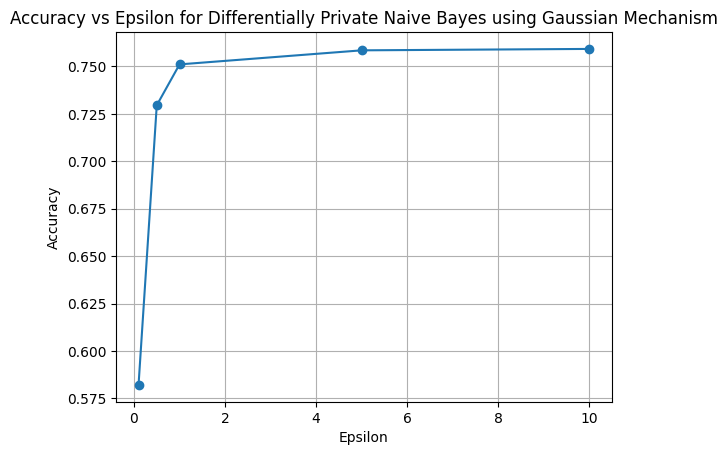

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np


# Define the values of epsilon to test
epsilon_values = [0.1, 0.5, 1, 5, 10]
accuracies = []

# Define other parameters
num_epochs = 10  # Example number of epochs
batch_size = 32  # Example batch size
sensitivity = 1.0 / batch_size  # Example sensitivity, adjust based on your model
delta = 1e-5  # Small delta for overall privacy budget

def compute_sigma(epsilon, delta, sensitivity):
    # Compute the standard deviation (sigma) of the Gaussian noise
    return np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon

for epsilon in epsilon_values:
    model = MultinomialNB()

    for epoch in range(num_epochs):
        for i in range(0, X_train_vect.shape[0], batch_size):
            # Extract batch
            X_batch = X_train_vect[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Train model on batch
            if i == 0 and epoch == 0:
                # Initialize the model with partial_fit on the first batch
                model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            else:
                model.partial_fit(X_batch, y_batch)

        # After each epoch, add noise to the model parameters (probabilities)
        sigma = compute_sigma(epsilon, delta, sensitivity)

        # Add Gaussian noise to the model parameters (probabilities)
        for feature_idx in range(model.feature_count_.shape[1]):
            noise = np.random.normal(0, sigma, 2)  # Generate noise for each class
            model.feature_log_prob_[0, feature_idx] += noise[0]
            model.feature_log_prob_[1, feature_idx] += noise[1]

    # Evaluate your model
    y_pred = model.predict(X_test_vect)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy}")

# Plot the results
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon for Differentially Private Naive Bayes using Gaussian Mechanism')
plt.grid(True)
plt.show()


###**The Laplace Mechanism**

Epsilon: 0.1, Accuracy: 0.6992070517770704
Epsilon: 0.5, Accuracy: 0.7559502508177475
Epsilon: 1, Accuracy: 0.7586499161848078
Epsilon: 5, Accuracy: 0.759305997651919
Epsilon: 10, Accuracy: 0.759368780567432


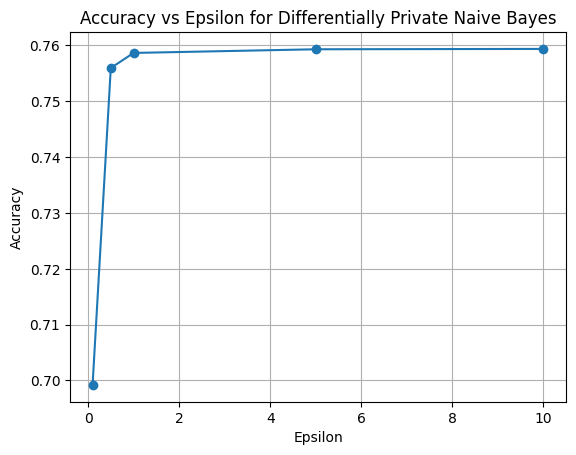

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

# Your data preparation code here
# Assuming X_train_bow, X_test_bow, y_train, y_test are already defined

# Define the values of epsilon to test
epsilon_values = [0.1, 0.5, 1, 5, 10]
accuracies = []

# Define other parameters
num_epochs = 10  # Example number of epochs
batch_size = 32  # Example batch size
sensitivity = 1.0 / batch_size  # Example sensitivity, adjust based on your model

for epsilon in epsilon_values:
    model = MultinomialNB()

    for epoch in range(num_epochs):
        for i in range(0, X_train_vect.shape[0], batch_size):
            # Extract batch
            X_batch = X_train_vect[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Train model on batch
            if i == 0 and epoch == 0:
                # Initialize the model with partial_fit on the first batch
                model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
            else:
                model.partial_fit(X_batch, y_batch)

        # After each epoch, add noise to the model parameters (probabilities)
        # Scale for differential privacy
        scale = sensitivity / epsilon

        # Add Laplace noise to the model parameters (probabilities)
        for feature_idx in range(model.feature_count_.shape[1]):
            noise = np.random.laplace(0, scale, 2)  # Generate noise for each class
            model.feature_log_prob_[0, feature_idx] += noise[0]
            model.feature_log_prob_[1, feature_idx] += noise[1]

    # Evaluate your model
    y_pred = model.predict(X_test_vect)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy}")

# Plot the results
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon for Differentially Private Naive Bayes')
plt.grid(True)
plt.show()